In [76]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import math
import matplotlib.pyplot as pyplot
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

### 1. Using hotel_cancellation.csv Download hotel_cancellation.csv, write code to estimate the treatment effects if a ‘different room is assigned’ as the treatment indicator and interpret its effect on the room being ‘canceled’. Use all the other columns as the covariates. Write your observations for the results.

In [2]:
### load hotel cancelation dataset
hotel = pd.read_csv("hotel_cancellation.csv")

In [29]:
### Create a binary indicator for the treatment variable (class)
hotel['different_room_assigned_numeric'] = (hotel['different_room_assigned'] == True).astype(int)
hotel['is_canceled_numeric'] = (hotel['is_canceled'] == True).astype(int)

### drop NAs in the data set
hotel = hotel.dropna(subset = hotel.columns).reset_index()

### check how many rows left
print("Number of rows left : ")
print(len(hotel))

Number of rows left : 
102894


In [31]:
# Specify the response and treatment variables
y = hotel['is_canceled_numeric']
x = hotel[['different_room_assigned_numeric', 'lead_time', 'arrival_date_year','arrival_date_day_of_month',\
            'days_in_waiting_list']]

# Fit a logistic regression model
model = sm.Logit(y, x)
result = model.fit()
          
# Print the treatment effect estimates
print(result.params)

Optimization terminated successfully.
         Current function value: 0.598744
         Iterations 7
different_room_assigned_numeric   -2.523757
lead_time                          0.005129
arrival_date_year                 -0.000425
arrival_date_day_of_month         -0.001518
days_in_waiting_list               0.001363
dtype: float64


In [32]:
math.exp(result.params[0])

0.08015792665629408

The output tells us the estimated treatment effects for each covariate in the model. The treatment effect for different_room_assigned represents the difference in the odds of canceling the reservation between customers who have been assigned to different rooms with those who haven't, controlling for the effects of lead_time, arrival_date_year,arrival_date_day_of_month, days_in_waiting_list and days_in_waiting_list.


A negative 2.5248 estimate for the treatment effect of different_room_assigned_numeric would indicate that customerst those have been assigned different rooms have approximately 0.08 times lower opportunity of canceling their reservation comparing to those who weren't assigned different rooms.

### 2. For hotel_cancellation.csv Download hotel_cancellation.csv, now use double logistic regression to measure the effect of ‘different room is assigned’ on the room being ‘canceled’..

In the first stage, a logistic regression model is fit to predict the probability of the main outcome as a function of the risk factor and other covariates. In the second stage, a logistic regression model is fit to predict the probability of the secondary outcome as a function of the risk factor, other covariates, and the predicted probability of the main outcome from the first stage.


So, double logistic regression is not just fitting two separate logistic regression models, but rather fitting two logistic regression models in two stages, with the results from the first stage being used as a predictor in the second stage.

In [33]:
model1 = sm.Logit(y, x).fit()

### creating predicted y (y hat) with model1, and store into n by 1 array
y_hat = np.array(model1.predict(x)).reshape(len(x), 1)

### combine y_hat and use as another predictor (with the old predictors in model1)
x_new = np.hstack((x, y_hat))

### new model model2 with y ~ y_hat + x
model2 = sm.Logit(y, x_new).fit()

print(model2.params)

Optimization terminated successfully.
         Current function value: 0.598744
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598690
         Iterations 7
x1   -1.997232
x2    0.003407
x3   -0.000642
x4   -0.001001
x5    0.000983
x6    1.460159
dtype: float64


In [34]:
math.exp(model2.params[0])

0.1357103454986114

Pure effect of "differet room is assigned" can be observed with coefficient of x1, a negative "-1.997232" estimate meaning that customers those have been assigned different rooms have approximately "0.1357103" times lower opportunity of canceling their reservation comparing to those who weren't assigned different rooms.

### 3. Use bootstrap to estimate the standard error of the treatment effects measured in (2).

In [63]:
# Define the number of bootstrap resamples
n_resamples = 1000

# Initialize a matrix to store the treatment effect estimates
treat_effects = np.zeros((n_resamples, model2.params.shape[0]))

# Use bootstrapping to estimate the standard error of the treatment effects
i = 0
while i < n_resamples:
    resample_index = np.random.choice(hotel.index, size = hotel.index.size, replace = True)
    resample = hotel.iloc[resample_index]
    x_resample = x.iloc[resample_index]
    y_resample = y.iloc[resample_index]
    model1 = sm.Logit(y_resample, x_resample).fit()
    y_hat = np.array(model1.predict(x_resample)).reshape(len(y_hat), 1)
    x_new = np.hstack((x_resample, y_hat))
    model2 = sm.Logit(y_resample, x_new).fit()
    treat_effects[i, :] = model2.params
    i += 1

# Calculate the standard error of the treatment effects
treat_effects_se = treat_effects.std(axis=0)

Optimization terminated successfully.
         Current function value: 0.600298
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.600273
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599964
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599920
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599506
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599460
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.600238
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.600127
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598422
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598334
  

Optimization terminated successfully.
         Current function value: 0.595155
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.595134
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599458
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599445
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598805
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598734
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598457
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598389
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598561
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598508
  

Optimization terminated successfully.
         Current function value: 0.600060
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599978
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599311
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599213
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.600512
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.600495
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598584
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598518
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598174
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598116
  

Optimization terminated successfully.
         Current function value: 0.598776
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598728
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599089
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599039
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599369
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599325
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599428
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599364
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599575
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599536
  

Optimization terminated successfully.
         Current function value: 0.596392
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596273
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599499
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599459
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598787
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598735
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598119
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598087
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.600549
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.600377
  

Optimization terminated successfully.
         Current function value: 0.598454
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598401
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598346
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598329
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598739
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598714
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598464
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598417
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597027
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596952
  

Optimization terminated successfully.
         Current function value: 0.597131
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597083
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599411
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599320
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.600031
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599999
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599918
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599860
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598903
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598820
  

Optimization terminated successfully.
         Current function value: 0.596895
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596770
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.595976
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.595961
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.600319
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.600279
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.600031
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599977
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597091
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597007
  

Optimization terminated successfully.
         Current function value: 0.600898
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.600847
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599482
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599441
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598636
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598590
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597860
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597807
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597099
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597065
  

Optimization terminated successfully.
         Current function value: 0.597230
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597204
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598637
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598517
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599293
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599241
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.600117
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.600089
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598403
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598289
  

Optimization terminated successfully.
         Current function value: 0.599407
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599373
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599304
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599109
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599777
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599742
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598599
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598579
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599064
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598992
  

Optimization terminated successfully.
         Current function value: 0.599703
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599653
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597922
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597874
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599576
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599549
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598883
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598876
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598901
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598866
  

Optimization terminated successfully.
         Current function value: 0.598201
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598177
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598043
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597996
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598809
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598740
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598483
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598413
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599262
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599216
  

Optimization terminated successfully.
         Current function value: 0.599533
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599442
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599139
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599099
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599698
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599660
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599348
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599283
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599920
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599855
  

Optimization terminated successfully.
         Current function value: 0.597192
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597105
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599284
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599220
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598631
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598565
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.600066
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.600031
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597814
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597813
  

Optimization terminated successfully.
         Current function value: 0.598206
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598193
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598556
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598453
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599122
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599080
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599317
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599252
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597686
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597633
  

Optimization terminated successfully.
         Current function value: 0.599592
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599554
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597374
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597322
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.601270
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.601179
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598213
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598129
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599626
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599536
  

Optimization terminated successfully.
         Current function value: 0.596684
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596642
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.600376
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.600335
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.600101
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.600053
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598696
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598666
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599131
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599069
  

Optimization terminated successfully.
         Current function value: 0.600564
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.600500
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598670
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598613
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598239
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598188
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596417
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596371
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598920
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598810
  

Optimization terminated successfully.
         Current function value: 0.599349
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599334
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598284
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598191
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598858
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598799
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597476
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597377
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596815
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596780
  

Optimization terminated successfully.
         Current function value: 0.599808
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599738
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599431
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599376
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599021
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598978
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597558
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597507
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597197
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597183
  

Optimization terminated successfully.
         Current function value: 0.599879
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599805
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598756
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598738
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597310
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597299
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599828
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599761
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598646
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598590
  

Optimization terminated successfully.
         Current function value: 0.600057
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599956
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597322
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597289
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.600022
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599989
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598999
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598862
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598189
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598109
  

Optimization terminated successfully.
         Current function value: 0.599526
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599480
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599876
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599868
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598976
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598922
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.600221
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.600113
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597948
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597862
  

Optimization terminated successfully.
         Current function value: 0.596481
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596449
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.595834
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.595803
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599746
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599702
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597318
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597258
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599619
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599553
  

In [65]:
# Print the standard errors of the treatment effect estimates
print('Standard errors of the treatment effects:')
print(treat_effects_se)

Standard errors of the treatment effects:
[1.70092619e-01 5.42159760e-04 6.69609041e-05 5.27868870e-04
 3.17292664e-04 4.54003120e-01]


As we discussed in class, a regression discontinuity design (RDD) is a quasi-experimental design that aims to determine the causal effects of interventions by studying observations close to a threshold above or below which an intervention is assigned (the example I used in class was “imagine college assignment only depended on your SAT score and the cutoff was 800 points to get into college”). By comparing observations lying closely on either side of the threshold, it is possible to estimate the marginal treatment effect in environments in which randomization is unfeasible (in the college example, one would compare the outcomes of all the people at score 800 to those at score 799).

### 4. Use the drinking.csv Download drinking.csv dataset for this question. Keeping 21 as the threshold for age, explore the data with an RDD by writing very simple code (no package needed, just average to one side of the threshold minus average to the other side) to determine if alcohol increases the chances of death by accident, suicide and/or others (the three given columns) and comment on the question “Should the legal age for drinking be reduced from 21?” based on the results. Plot graphs to show the discontinuity (if any) and to show results for the change in chances of death with all the three features (i.e., accident vs age, suicide vs age and others vs age). For this problem, choose the bandwidth to be 1 year (i.e., 21 +- 1). What might be the effect of choosing a smaller bandwidth?  What if we chose the maximum bandwidth?

In [26]:
drink = pd.read_csv("drinking.csv")

In [59]:
### category variable
drink['threshold'] = drink['age'] > 21

In [66]:
### dataframe for teenager greater than 20 but smaller than 21
df_20_to_21 = drink[(drink['age'] >= 20) & (drink['age'] < 21)]

### dataframe for teenager greater than 21 but smaller than 22
df_21_to_22 = drink[(drink['age'] >= 21) & (drink['age'] < 22)]

In [67]:
### accident
print("Chances of 20-21 year-old death from accident : ",df_20_to_21['accident'].mean())

print("Chances of 21-22 year-old death from accident : ",df_21_to_22['accident'].mean())

Chances of 20-21 year-old death from accident :  31.296563333333328
Chances of 21-22 year-old death from accident :  32.63504916666667


In [68]:
### suicide
print("Chances of 20-21 year-old death from suicide : ",df_20_to_21['suicide'].mean())

print("Chances of 21-22 year-old death from suicide : ",df_21_to_22['suicide'].mean())

Chances of 20-21 year-old death from suicide :  11.642919833333332
Chances of 21-22 year-old death from suicide :  13.361998166666668


In [69]:
### others
print("Chances of 20-21 year-old death from others : ",df_20_to_21['others'].mean())

print("Chances of 21-22 year-old death from others : ",df_21_to_22['others'].mean())

Chances of 20-21 year-old death from others :  93.31885033333333
Chances of 21-22 year-old death from others :  99.86051041666667


All chances are higher for people with age between 21-22 comparing to those with age between 20-21!

**Question : Should the legal age for drinking be reduced from 21?**

I think the legal age for drinking should mot be reduced from 21, because we can spot increase in chances of death for either of the category, which means that alcohol can be a potentially dangerous for teenagers.

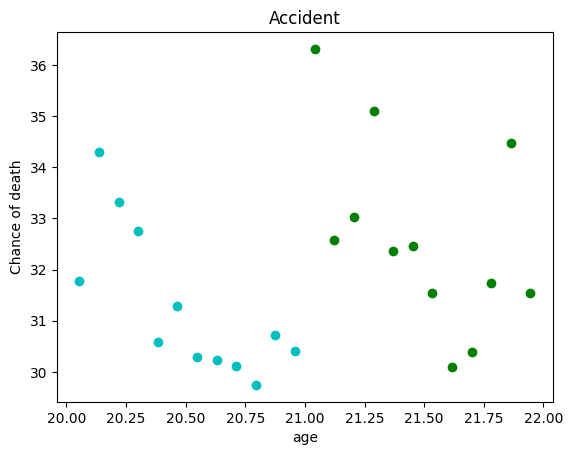

In [72]:
pyplot.scatter(df_20_to_21['age'], df_20_to_21['accident'] , label = 'below 21', color='c')
pyplot.scatter(df_21_to_22['age'], df_21_to_22['accident'] , label = 'over 21', color='g')
pyplot.title("Accident")
pyplot.xlabel("age")
pyplot.ylabel("Chance of death")

pyplot.show()

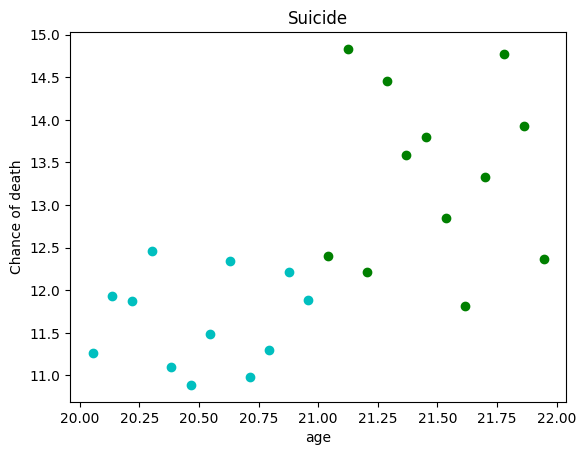

In [73]:
pyplot.scatter(df_20_to_21['age'], df_20_to_21['suicide'] , label = 'below 21', color='c')
pyplot.scatter(df_21_to_22['age'], df_21_to_22['suicide'] , label = 'over 21', color='g')
pyplot.title("Suicide")
pyplot.xlabel("age")
pyplot.ylabel("Chance of death")

pyplot.show()

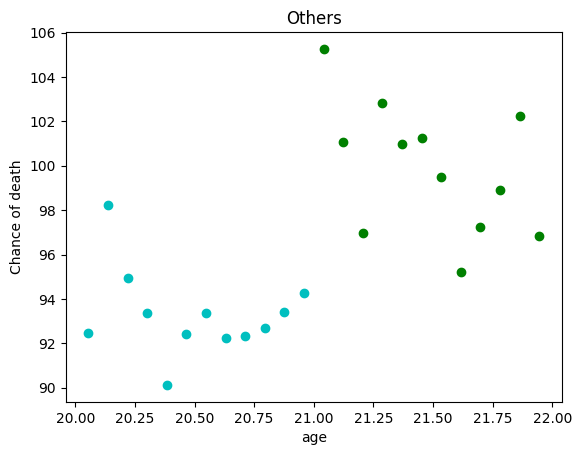

In [74]:
pyplot.scatter(df_20_to_21['age'], df_20_to_21['others'] , label = 'below 21', color='c')
pyplot.scatter(df_21_to_22['age'], df_21_to_22['others'] , label = 'over 21', color='g')
pyplot.title("Others")
pyplot.xlabel("age")
pyplot.ylabel("Chance of death")

pyplot.show()

### Smaller bandwidth (0.1 years)

In [79]:
### dataframe for teenager greater than 20 but smaller than 21
df_209_to_21 = drink[(drink['age'] >= 20.9) & (drink['age'] < 21)]

### dataframe for teenager greater than 21 but smaller than 22
df_21_to_211 = drink[(drink['age'] >= 21) & (drink['age'] < 21.1)]

In [80]:
### accident
print("Chances of 20.9-21 year-old death from accident : ",df_209_to_21['accident'].mean())

print("Chances of 21-21.1 year-old death from accident : ",df_21_to_211['accident'].mean())

Chances of 20.5-21 year-old death from accident :  30.417139
Chances of 21-21.5 year-old death from accident :  36.316807


In [81]:
### suicide
print("Chances of 20.9-21 year-old death from suicide : ",df_209_to_21['suicide'].mean())

print("Chances of 21-21.1 year-old death from suicide : ",df_21_to_211['suicide'].mean())

Chances of 20.5-21 year-old death from suicide :  11.880486
Chances of 21-21.5 year-old death from suicide :  12.402751


In [82]:
### others
print("Chances of 20.9-21 year-old death from others : ",df_209_to_21['others'].mean())

print("Chances of 21-21.1 year-old death from others : ",df_21_to_211['others'].mean())

Chances of 205-21 year-old death from others :  94.269913
Chances of 21-215 year-old death from others :  105.26835


When we smaller the bandwidth and make it as 0.1 year, the difference between larger, I think this is resulted from the way of the data points are scattered. In the graphs we can see that from either of the categories, opportunity of death peaked at the point of 21 year-old, therefore making the difference even larger under a smaller bandwidth.

### Max bandwidth

In [83]:
df_smaller_21 = drink[drink['age'] < 21]
df_greater_21 = drink[drink['age'] >= 21]

In [86]:
### accident
print("Chances of teenagers smaller than 21 year-old death from accident : ",df_smaller_21['accident'].mean())

print("Chances of teenager over 21 year-old death from accident : ",df_greater_21['accident'].mean() , '\n')

### suicide
print("Chances of teenagers smaller than 21 year-old death from suicide : ",df_smaller_21['suicide'].mean())

print("Chances of teenager over 21 year-old death from suicide : ",df_greater_21['suicide'].mean(), '\n')


### others
print("Chances of teenagers smaller than 21 year-old death from others : ",df_smaller_21['others'].mean())

print("Chances of teenager over 21 year-old death from others : ",df_greater_21['others'].mean())

Chances of teenagers smaller than 21 year-old death from accident :  32.461662
Chances of teenager over 21 year-old death from accident :  30.784306041666667 

Chances of teenagers smaller than 21 year-old death from suicide :  11.633759416666669
Chances of teenager over 21 year-old death from suicide :  13.070201333333332 

Chances of teenagers smaller than 21 year-old death from others :  92.80270237500001
Chances of teenager over 21 year-old death from others :  98.54274654166669


For Death from "accident", the results reverse with those over 21 years old having smaller chances. On the other hand, for suicide and others, there don't seem to be big differences.

k-Nearest Neighbors (kNN) is a machine learning algorithm used for both classification and regression problems. In a kNN algorithm, data points are stored, and a prediction is made for a new data point by identifying the k nearest data points to the new data point and aggregating the results from those k data points. In a classification problem, if k = 3, the three nearest data points to the new data point are examined, and the most frequent class among those three data points is assigned as the predicted class for the new data point. In a regression problem, the mean or median value of the k nearest data points is used as the predicted output value for the new data point.

### 5. Use the iris.csv Download iris.csv dataset for this question. How does the performance of k-nearest neighbors change as k takes on the following values: 1, 3, 5, 7? Which of these is the optimal value of k? Which distance/similarity metric did you choose to use and why?

In [4]:
iris = pd.read_csv("iris.csv")

In [60]:
from sklearn.neighbors import KNeighborsClassifier

In [50]:
### specify predictors and predicted value
y = iris['variety']
X = iris[["sepal.length" , "sepal.width" , "petal.length" , "petal.width"]]

In [117]:
### splitting into test and train dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 178)


In [124]:
### function for k, and distance matrix test
def knn_with_k_and_dis(k , dis):    
    ### specify model with k number of neighbors and distance matrix
    knn = KNeighborsClassifier(n_neighbors = k , metric = dis)
    
    ### fit the model
    knn.fit(X_train, y_train)
    
    score = knn.score(X_test, y_test) 
    
    ### print score
    print(f"Score for model with number of k = {k} : ", score , '\n')
    
    ### return score
    return score

In [143]:
### plot error rate and number of k
def plot_error_rate(error_list):
    pyplot.figure(figsize = (5 , 3))
    pyplot.plot([1, 3, 5, 7] , error_list,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=8)
    pyplot.title('Error Rate vs. K Value', fontsize = 12)
    pyplot.xlabel('K',fontsize = 8)
    pyplot.ylabel('Error (misclassification) Rate',fontsize = 8)

### Euclidean distance

Score for model with number of k = 1 :  0.9333333333333333 

Score for model with number of k = 3 :  0.9333333333333333 

Score for model with number of k = 5 :  1.0 

Score for model with number of k = 7 :  1.0 



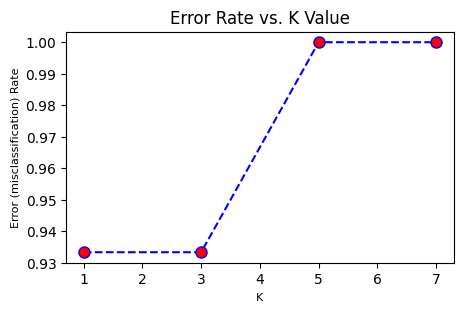

In [144]:
error_list = []

### K = 1
one = knn_with_k_and_dis(1 , 'euclidean')
error_list.append(one)

### k = 3
three = knn_with_k_and_dis(3 , 'euclidean')
error_list.append(three)

### k = 5
five = knn_with_k_and_dis(5 , 'euclidean')
error_list.append(five)

### k = 7
seven = knn_with_k_and_dis(7 , 'euclidean')
error_list.append(seven)

plot_error_rate(error_list)

### minkowski

Score for model with number of k = 1 :  0.9333333333333333 

Score for model with number of k = 3 :  0.9333333333333333 

Score for model with number of k = 5 :  1.0 

Score for model with number of k = 7 :  1.0 



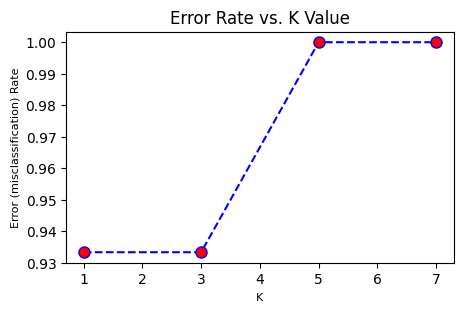

In [145]:
error_list = []

### K = 1
one = knn_with_k_and_dis(1 , 'minkowski')
error_list.append(one)

### k = 3
three = knn_with_k_and_dis(3 , 'minkowski')
error_list.append(three)

### k = 5
five = knn_with_k_and_dis(5 , 'minkowski')
error_list.append(five)

### k = 7
seven = knn_with_k_and_dis(7 , 'minkowski')
error_list.append(seven)

plot_error_rate(error_list)


### Manhattan distance

Score for model with number of k = 1 :  0.9333333333333333 

Score for model with number of k = 3 :  0.9666666666666667 

Score for model with number of k = 5 :  0.9666666666666667 

Score for model with number of k = 7 :  0.9666666666666667 



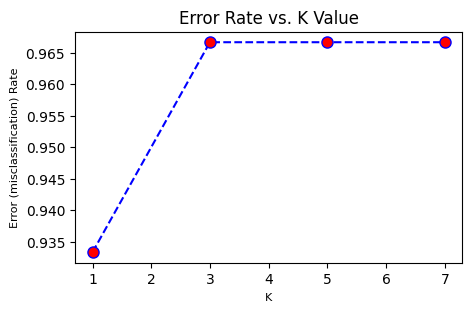

In [146]:
### K = 1
error_list = []

### K = 1
one = knn_with_k_and_dis(1 , 'cityblock')
error_list.append(one)

### k = 3
three = knn_with_k_and_dis(3 , 'cityblock')
error_list.append(three)

### k = 5
five = knn_with_k_and_dis(5 , 'cityblock')
error_list.append(five)

### k = 7
seven = knn_with_k_and_dis(7 , 'cityblock')
error_list.append(seven)

plot_error_rate(error_list)

### Optimal value of k?

From the above trials, I think the best value for **k is 5**, given that the performance between k=5 under either disdtance calculation is more stable

### Which distance/similarity metric did you choose to use and why?

**Minkowski metric**

Minkowski distance is more sound under n-dimensional spaces, in our cases, while we have more than two dimensions, Minkowski might be a better distance measure to apply here. 